In [7]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [8]:
dataset = pd.read_csv('finviz_dataset_spy.csv')

In [9]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,Ticker,Open,Close,High,Low,Volume
0,1429189200,SPY,210.03,210.37,210.98,209.793,68934864
1,1429275600,SPY,208.94,207.95,209.23,207.010,191113232
2,1429534800,SPY,209.06,209.85,210.25,208.960,92189480
3,1429621200,SPY,210.67,209.60,210.86,209.240,72559832
4,1429707600,SPY,210.01,210.63,210.85,208.900,78264616
...,...,...,...,...,...,...,...
2506,1743598800,SPY,555.05,564.52,567.42,554.810,76014544
2507,1743685200,SPY,545.11,536.70,547.97,536.700,125986000
2508,1743771600,SPY,523.67,505.28,525.87,505.060,217965136
2509,1744030800,SPY,489.19,504.38,523.17,481.800,256611360


In [10]:
def calculateFields(dataset):
    if 'Date' not in dataset:
        dataset['Date'] = dataset['date']
        dataset = dataset.drop(columns=["date"])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj Close'])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj_close'])
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
    dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
    dataset = dataset.drop(columns=["Volume", "Close", "Open", "Low", "High"])
    dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Year'] = dataset['Date'].dt.year
    dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
    dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

    dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
    dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
    dataset['quarter'] = dataset['Date'].dt.quarter
    def get_season(month):
        if month in [12, 1, 2]:
            return 0#'winter'
        elif month in [3, 4, 5]:
            return 1#'spring'
        elif month in [6, 7, 8]:
            return 2#'summer'
        else:
            return 3#'autumn'
    dataset['season'] = dataset['Month'].apply(get_season)
    dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


    days_ago = 30

    #dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
    #dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
    #dataset["price_365_days_ago"] = dataset["average_price"].shift(365)


    dataset = dataset.dropna().reset_index(drop=True)
    if 'Symbol' in dataset:
        dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
    else:
        dataset['Symbol'] = pd.factorize(dataset.Ticker)[0]
        dataset = dataset.drop(columns=['Ticker'])

    return dataset

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber"]  #, "price_30_days_ago", "price_180_days_ago", "price_365_days_ago", 'Symbol']
fieldsPrice = ["average_price"]

dataset["Date"] = pd.to_datetime(dataset["Date"], unit="s")
dataset = calculateFields(dataset)
dataset

,Date,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,Symbol
0,2015-04-16 13:00:00,735704,210.3865,3,4,2015,106,16,0,0,2,1,1,0
1,2015-04-17 13:00:00,735705,208.1200,4,4,2015,107,16,0,0,2,1,2,0
2,2015-04-20 13:00:00,735708,209.6050,0,4,2015,110,17,0,0,2,1,5,0
3,2015-04-21 13:00:00,735709,210.0500,1,4,2015,111,17,0,0,2,1,6,0
4,2015-04-22 13:00:00,735710,209.8750,2,4,2015,112,17,0,0,2,1,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,2025-04-02 13:00:00,739343,561.1150,2,4,2025,92,14,0,0,2,1,3640,0
2507,2025-04-03 13:00:00,739344,542.3350,3,4,2025,93,14,0,0,2,1,3641,0
2508,2025-04-04 13:00:00,739345,515.4650,4,4,2025,94,14,0,0,2,1,3642,0
2509,2025-04-07 13:00:00,739348,502.4850,0,4,2025,97,15,0,0,2,1,3645,0


In [11]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [12]:
from datetime import datetime

def generateRandomDate():
    max_date = pd.to_datetime(dataset['Date'].max())
    max_valid_date = max_date - pd.DateOffset(years=3)
    min_valid_date = pd.to_datetime(dataset['Date'].min())

    delta = (max_valid_date - min_valid_date).days
    random_days = np.random.randint(0, delta + 1)
    random_date0 = min_valid_date + pd.Timedelta(days=random_days)
    return random_date0

random_date = datetime.strptime("30/3/2020", "%d/%m/%Y") #generateRandomDate()

In [13]:
filtered_df = dataset[(dataset['Date'] >= random_date)]

In [14]:
testRanges = [1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361]
train_days = 365
nJobs = 5
nEstimators = 100
block_size = 20

In [15]:
def getTrainTest(filtered_df0, pivote_date0, head=29):
    max_train_day = pivote_date0 + pd.DateOffset(years=1)
    blockDf = filtered_df0[(filtered_df0['Date'] >= pivote_date0) & (filtered_df0['Date'] <= max_train_day)]
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_train0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_train0 = aux.copy()
    
    #Se toman los siguientes 29 días hábiles
    blockDf = filtered_df0[filtered_df0["Date"] > max_train_day].head(head)
    #filtered_df0[(filtered_df0['Date'] > max_train_day) & (filtered_df0['Date'] <= max_test_day)]
    
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_test0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test0 = aux.copy()

    return X_train0, Y_train0, X_test0, Y_test0

In [16]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

resultBasicRF = dict()
resultNonOverlapping = dict()
resultMovingBlock = dict()
resultCircularBlock = dict()

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

pivote_date = random_date
for testRange in testRanges:
    X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, pivote_date)
    basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    basicRFPrecision[testRange] = rmse0
    resultBasicRF[testRange] = (Y_test["average_price"].values[0], y_pred[0])

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionNonOverlapping[testRange] = rmse0
    resultNonOverlapping[testRange] = (Y_test["average_price"].values[0], y_pred[0])

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionMovingBlock[testRange] = rmse0
    resultMovingBlock[testRange] = (Y_test["average_price"].values[0], y_pred[0])

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionCircularBlock[testRange] = rmse0
    resultCircularBlock[testRange] = (Y_test["average_price"].values[0], y_pred[0])
    
    pivote_date = random_date + pd.DateOffset(days=testRange)

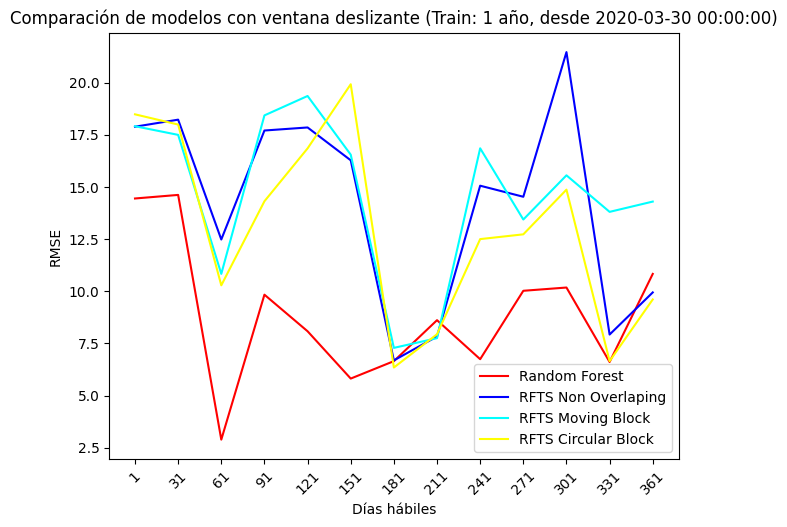

In [18]:
labels = list(basicRFPrecision.keys())
all_arr0 = list(basicRFPrecision.values())
all_arr = list(precisionNonOverlapping.values())
all_arr1 = list(precisionMovingBlock.values())
all_arr2 = list(precisionCircularBlock.values())


bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    
plt.legend()

plt.xticks(range(0, len(labels)), labels)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("RMSE")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=45)

plt.show()

In [19]:
expectedValuesRf = []
predictedValuesRf = []
predictedValuesRftsNO = []
predictedValuesRftsMB = []
predictedValuesRftsCB = []

for kTestRange in resultBasicRF:
    expectedValuesRf.append(resultBasicRF[kTestRange][0])
    predictedValuesRf.append(resultBasicRF[kTestRange][1])
for kTestRange in resultBasicRF:
    predictedValuesRftsNO.append(resultNonOverlapping[kTestRange][1])
for kTestRange in resultBasicRF:
    predictedValuesRftsMB.append(resultMovingBlock[kTestRange][1])
for kTestRange in resultBasicRF:
    predictedValuesRftsCB.append(resultCircularBlock[kTestRange][1])

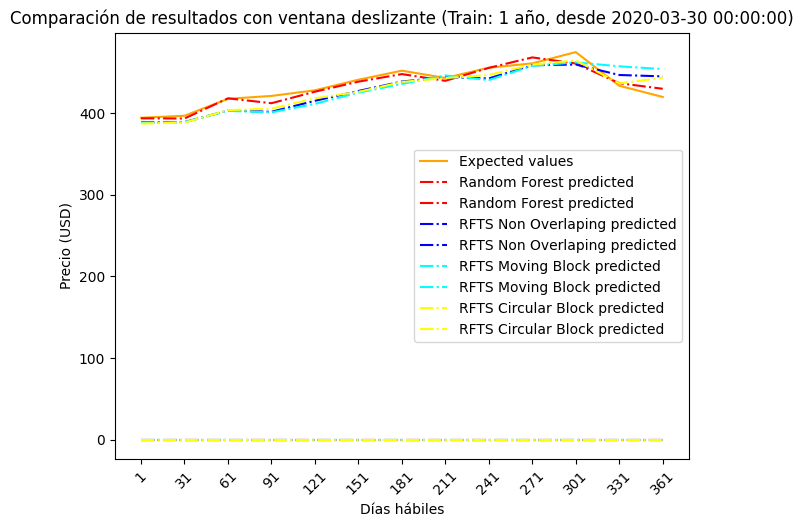

In [20]:
bp = plt.plot(expectedValuesRf, color='orange', label="Expected values", linestyle='-')
bp0 = plt.plot(predictedValuesRf, color='red', label="Random Forest predicted", linestyle='-.')
bp1 = plt.plot(predictedValuesRftsNO, color='blue', label="RFTS Non Overlaping predicted", linestyle='-.')
bp2 = plt.plot(predictedValuesRftsMB, color='cyan', label="RFTS Moving Block predicted", linestyle='-.')
bp3 = plt.plot(predictedValuesRftsCB, color='yellow', label="RFTS Circular Block predicted", linestyle='-.')


plt.legend()

plt.xticks(range(0, len(labels)), labels)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("Precio (USD)")
plt.title(f"Comparación de resultados con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=45)

plt.show()

In [21]:
basicRFPrecision2 = dict()
precisionNonOverlapping2 = dict()
precisionMovingBlock2 = dict()
precisionCircularBlock2 = dict()
for testRange in testRanges:
    basicRFPrecision2[testRange] = []
    precisionNonOverlapping2[testRange] = []
    precisionMovingBlock2[testRange] = []
    precisionCircularBlock2[testRange] = []

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

random_date2 = generateRandomDate()
filtered_df0 = dataset[(dataset['Date'] >= random_date2)]
for i in range(50):
    pivote_date = random_date2
    for testRange in testRanges:
        X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df0, pivote_date)
        basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
        basicRF.fit(X_train, Y_train)
        y_pred = basicRF.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        basicRFPrecision2[testRange].append(rmse0)

        rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionNonOverlapping2[testRange].append(rmse0)

        rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionMovingBlock2[testRange].append(rmse0)

        rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionCircularBlock2[testRange].append(rmse0)
        
        pivote_date = random_date2 + pd.DateOffset(days=testRange)
    random_date2 = generateRandomDate()
    filtered_df0 = dataset[(dataset['Date'] >= random_date2)]

In [23]:
for testRange in testRanges:
    basicRFPrecision2[testRange] = sum(basicRFPrecision2[testRange]) / len(basicRFPrecision2[testRange])
    precisionNonOverlapping2[testRange] = sum(precisionNonOverlapping2[testRange]) / len(precisionNonOverlapping2[testRange])
    precisionMovingBlock2[testRange] = sum(precisionMovingBlock2[testRange]) / len(precisionMovingBlock2[testRange])
    precisionCircularBlock2[testRange] = sum(precisionCircularBlock2[testRange]) / len(precisionCircularBlock2[testRange])

In [24]:
basicRFPrecision2

{1: 9.073436538326597,
 31: 8.852795364955247,
 61: 9.173166569377283,
 91: 9.556536946728771,
 121: 8.71829457837711,
 151: 7.857403355068916,
 181: 7.6247581955883765,
 211: 7.833679196755728,
 241: 8.027886482418982,
 271: 7.754551323664596,
 301: 8.24831935078181,
 331: 7.493861093211964,
 361: 8.408544921596484}

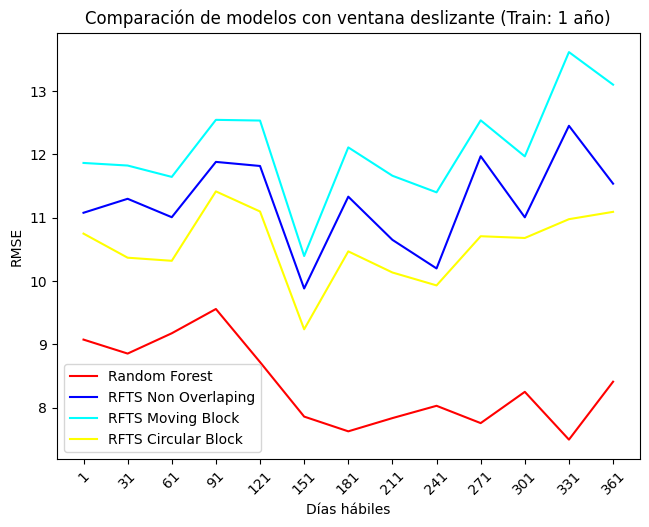

In [25]:
labels = list(basicRFPrecision.keys())
all_arr0 = list(basicRFPrecision2.values())
all_arr = list(precisionNonOverlapping2.values())
all_arr1 = list(precisionMovingBlock2.values())
all_arr2 = list(precisionCircularBlock2.values())


bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    
plt.legend()

plt.xticks(range(0, len(labels)), labels)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("RMSE")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año)")
plt.xticks(rotation=45)

plt.show()

In [26]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

In [27]:
pivote_date = random_date
for testRange in testRanges[:5]:
    X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, pivote_date)
    basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    basicRFPrecision[testRange] = rmse0
    X_test0 = X_test.tail(22)
    Y_test0 = Y_test.tail(22)
    y_pred = basicRF.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    basicRFPrecision[testRange + 7] = rmse0
    X_test1 = X_test.tail(15)
    Y_test1 = Y_test.tail(15)
    y_pred = basicRF.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    basicRFPrecision[testRange + 14] = rmse0
    X_test2 = X_test.tail(8)
    Y_test2 = Y_test.tail(8)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    basicRFPrecision[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionNonOverlapping[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionNonOverlapping[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionNonOverlapping[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionNonOverlapping[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionMovingBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionMovingBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionMovingBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionMovingBlock[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionCircularBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionCircularBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionCircularBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionCircularBlock[testRange + 21] = rmse0
    
    pivote_date = random_date + pd.DateOffset(days=testRange)

In [28]:
ticks001 = []
for testRange in testRanges[:5]:
    ticks001.append(str(testRange))
    ticks001.append(str(testRange + 7))
    ticks001.append(str(testRange + 14))
    ticks001.append(str(testRange + 21))

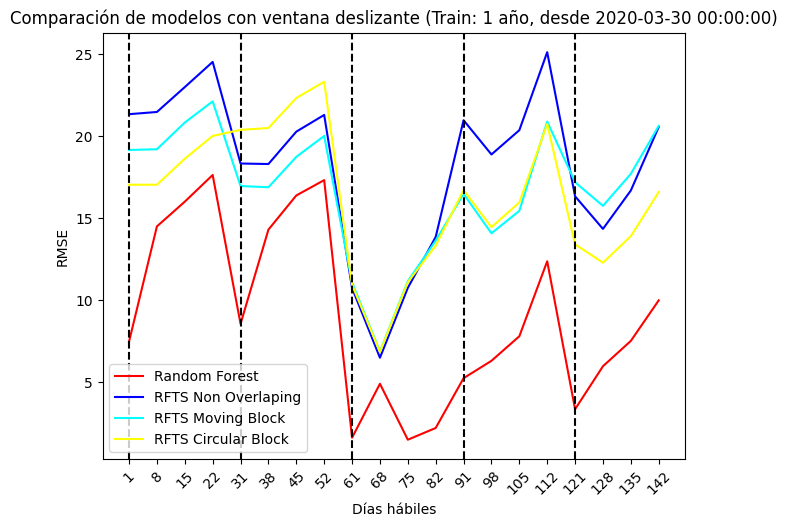

In [29]:
all_arr0 = list(basicRFPrecision.values())
all_arr = list(precisionNonOverlapping.values())
all_arr1 = list(precisionMovingBlock.values())
all_arr2 = list(precisionCircularBlock.values())


bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    
plt.legend()

plt.xticks(range(0, len(ticks001)), ticks001)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("RMSE")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=45)

i = 0
for testRange in testRanges[:5]:
    plt.axvline(x=i * 4, color='black', linestyle='--')
    i+=1

plt.show()

In [30]:
testRanges2 = [1, 61, 121, 181, 241, 301]

In [31]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

In [32]:
pivote_date = random_date
for testRange in testRanges2:
    X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, pivote_date, 59)
    basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    basicRFPrecision[testRange] = rmse0
    X_test0 = X_test.tail(52)
    Y_test0 = Y_test.tail(52)
    y_pred = basicRF.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    basicRFPrecision[testRange + 7] = rmse0
    X_test1 = X_test.tail(45)
    Y_test1 = Y_test.tail(45)
    y_pred = basicRF.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    basicRFPrecision[testRange + 14] = rmse0
    X_test2 = X_test.tail(38)
    Y_test2 = Y_test.tail(38)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    basicRFPrecision[testRange + 21] = rmse0
    X_test3 = X_test.tail(31)
    Y_test3 = Y_test.tail(31)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test3.head(7), y_pred))
    basicRFPrecision[testRange + 28] = rmse0
    X_test4 = X_test.tail(24)
    Y_test4 = Y_test.tail(24)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test4.head(7), y_pred))
    basicRFPrecision[testRange + 35] = rmse0
    X_test5 = X_test.tail(17)
    Y_test5 = Y_test.tail(17)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test5.head(7), y_pred))
    basicRFPrecision[testRange + 42] = rmse0
    X_test6 = X_test.tail(10)
    Y_test6 = Y_test.tail(10)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test6.head(7), y_pred))
    basicRFPrecision[testRange + 49] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionNonOverlapping[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionNonOverlapping[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionNonOverlapping[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionNonOverlapping[testRange + 21] = rmse0
    y_pred = rfts.predict(X_test3.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test3.head(7), y_pred))
    precisionNonOverlapping[testRange + 28] = rmse0
    y_pred = rfts.predict(X_test4.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test4.head(7), y_pred))
    precisionNonOverlapping[testRange + 35] = rmse0
    y_pred = rfts.predict(X_test5.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test5.head(7), y_pred))
    precisionNonOverlapping[testRange + 42] = rmse0
    y_pred = rfts.predict(X_test6.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test6.head(7), y_pred))
    precisionNonOverlapping[testRange + 49] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionMovingBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionMovingBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionMovingBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionMovingBlock[testRange + 21] = rmse0
    y_pred = rfts.predict(X_test3.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test3.head(7), y_pred))
    precisionMovingBlock[testRange + 28] = rmse0
    y_pred = rfts.predict(X_test4.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test4.head(7), y_pred))
    precisionMovingBlock[testRange + 35] = rmse0
    y_pred = rfts.predict(X_test5.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test5.head(7), y_pred))
    precisionMovingBlock[testRange + 42] = rmse0
    y_pred = rfts.predict(X_test6.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test6.head(7), y_pred))
    precisionMovingBlock[testRange + 49] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionCircularBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionCircularBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionCircularBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionCircularBlock[testRange + 21] = rmse0
    y_pred = rfts.predict(X_test3.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test3.head(7), y_pred))
    precisionCircularBlock[testRange + 28] = rmse0
    y_pred = rfts.predict(X_test4.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test4.head(7), y_pred))
    precisionCircularBlock[testRange + 35] = rmse0
    y_pred = rfts.predict(X_test5.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test5.head(7), y_pred))
    precisionCircularBlock[testRange + 42] = rmse0
    y_pred = rfts.predict(X_test6.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test6.head(7), y_pred))
    precisionCircularBlock[testRange + 49] = rmse0
    
    pivote_date = random_date + pd.DateOffset(days=testRange)

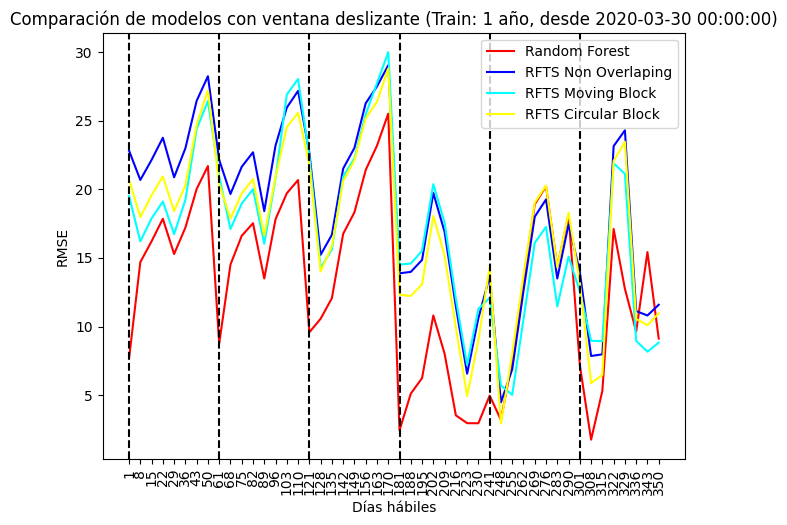

In [33]:
ticks002 = []
for testRange in testRanges2:
    ticks002.append(str(testRange))
    ticks002.append(str(testRange + 7))
    ticks002.append(str(testRange + 14))
    ticks002.append(str(testRange + 21))
    ticks002.append(str(testRange + 28))
    ticks002.append(str(testRange + 35))
    ticks002.append(str(testRange + 42))
    ticks002.append(str(testRange + 49))

all_arr0 = list(basicRFPrecision.values())
all_arr = list(precisionNonOverlapping.values())
all_arr1 = list(precisionMovingBlock.values())
all_arr2 = list(precisionCircularBlock.values())


bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    
plt.legend()

plt.xticks(range(0, len(ticks002)), ticks002)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("RMSE")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=90)

i = 0
for testRange in testRanges2:
    plt.axvline(x=i * 8, color='black', linestyle='--')
    i+=1

plt.show()